In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import dotenv
from sqlalchemy import create_engine, text

dotenv.load_dotenv()

True

In [2]:
df = pd.read_csv("data/data.csv")
df

crm_contact_functietitel  \
0                     Business Relations +  Development   
1               Zaakv. vennootsch. beperkte aansprakel.   
2               Zaakv. vennootsch. beperkte aansprakel.   
3                                    Algemeen Directeur   
4                                                   NaN   
...                                                 ...   
100014                             Export Sales Manager   
100015                                      Zaakvoerder   
100016  Vakexpert bedrijfssoftware en bedrijfsprocessen   
100017   Management-, communicatie- en marketingsupport   
100018                                   Office Manager   

        crm_contact_voka_medewerker crm_persoon_mail_thema_duurzaamheid  \
0                               0.0                                 Nee   
1                               0.0                                 Nee   
2                               0.0                                 Nee   
3                               0.0                                 Nee   
4                               0.0                                 Nee   
...                             ...                                 ...   
100014                          0.0                                 Nee   
100015                          0.0                                 Nee   
100016                          0.0                                 Nee   
100017                          0.0                                  Ja   
100018                          0.0                                 Nee   

       crm_persoon_mail_thema_financieel_fiscaal  \
0                                            Nee   
1                                            Nee   
2                                            Nee   
3                                            Nee   
4                                             Ja   
...                                          ...   
100014                                       Nee   
100015                                       Nee   
100016                                       Nee   
100017                                       Nee   
100018                                       Nee   

       crm_persoon_mail_thema_innovatie  \
0                                   Nee   
1                                   Nee   
2                                   Nee   
3                                   Nee   
4                                   Nee   
...                                 ...   
100014                              Nee   
100015                              Nee   
100016                              Nee   
100017                               Ja   
100018                              Nee   

       crm_persoon_mail_thema_internationaal_ondernemen  \
0                                                   Nee   
1                                                   Nee   
2                                                   Nee   
3                                                   Nee   
4                                                   Nee   
...                                                 ...   
100014                                              Nee   
100015                                              Nee   
100016                                              Nee   
100017                                              Nee   
100018                                              Nee   

       crm_persoon_mail_thema_mobiliteit crm_persoon_mail_thema_omgeving  \
0                                    Nee                             Nee   
1                                    Nee                             Nee   
2                                    Nee                             Nee   
3                                    Nee                             Nee   
4                                    Nee                             Nee   
...                                  ...                             ...   
100014                               N

In [3]:
X_df, y_df = df.drop(columns=["attended"]), df["attended"]

X_df.shape, y_df.shape

((100019, 272), (100019,))

In [4]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X_df, y_df, test_size=0.1, random_state=42
)

X_val_df, X_test_df, y_val_df, y_test_df = train_test_split(
    X_test_df, y_test_df, test_size=0.25, random_state=42
)

X_train_df.shape, X_val_df.shape, X_test_df.shape

((90017, 272), (7501, 272), (2501, 272))

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Based on unique values, decide what to do with the columns
single_cols = []  # 1 unique value

df_objects = X_train_df.select_dtypes(include="object").columns

# Label encode the columns
label_encoder = LabelEncoder()
X_df_encoded = X_df.copy()
for col in df_objects:
    X_df_encoded[col] = label_encoder.fit_transform(X_df_encoded[col])
    X_train_df[col] = label_encoder.transform(X_train_df[col])
    X_val_df[col] = label_encoder.transform(X_val_df[col])
    X_test_df[col] = label_encoder.transform(X_test_df[col])

# Assert that all columns are numeric or float
assert X_train_df.select_dtypes(include="object").shape[1] == 0

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
imp.fit(X_df_encoded)
X_train_df = imp.transform(X_train_df)
X_val_df = imp.transform(X_val_df)
X_test_df = imp.transform(X_test_df)

# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_df = scaler.fit_transform(X_train_df)
X_val_df = scaler.transform(X_val_df)
X_test_df = scaler.transform(X_test_df)

# Assert that there are no NaNs

# Save the scaler, label encoder and imputer
import pickle

with open(os.path.join(os.getenv("EPIC_3_SAVE_LOCATION"), "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

with open(
    os.path.join(os.getenv("EPIC_3_SAVE_LOCATION"), "label_encoder.pkl"), "wb"
) as f:
    pickle.dump(label_encoder, f)

with open(os.path.join(os.getenv("EPIC_3_SAVE_LOCATION"), "imputer.pkl"), "wb") as f:
    pickle.dump(imp, f)

assert np.isnan(X_train_df).sum() == 0
X_train_df.shape, X_val_df.shape, X_test_df.shape, y_train_df.shape

((90017, 272), (7501, 272), (2501, 272), (90017,))

In [6]:
# Make sure there are no NaN values
assert np.isnan(X_train_df).any() == False
assert np.isnan(X_test_df).any() == False

In [7]:
# Get the sklearn model for binary classification random forest
# Apply a grid search to find the best parameters

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
params = {
    "bootstrap": [True],
    "max_depth": [80, 90, 110],
    "max_features": [2, 3],
    "min_samples_leaf": [3, 4, 5],
    "min_samples_split": [8, 10, 12],
    "n_estimators": [100, 300, 1000],
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=rf, param_grid=params, cv=3, n_jobs=-1, verbose=2
)

# Fit the grid search to the data
grid_search.fit(X_train_df, y_train_df)

grid_search.best_params_

# Get the best model
clf = grid_search.best_estimator_

# Get the best model

# Save the model
with open(os.path.join(os.getenv("EPIC_3_SAVE_LOCATION"), "model.pkl"), "wb") as f:
    pickle.dump(clf, f)

# Get the predictions
y_pred_train = clf.predict(X_train_df)
y_pred_val = clf.predict(X_val_df)
y_pred_test = clf.predict(X_test_df)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [8]:
# Get the accuracy
from sklearn.metrics import accuracy_score

accuracy_score(y_train_df, y_pred_train), accuracy_score(
    y_val_df, y_pred_val
), accuracy_score(y_test_df, y_pred_test)

(0.8395080929157825, 0.8382882282362352, 0.846061575369852)

In [13]:
# Get the precision, recall and f1 score
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_train_df, y_pred_train, average="binary")

precision_recall_fscore_support(y_val_df, y_pred_val, average="binary")

precision_recall_fscore_support(y_test_df, y_pred_test, average="binary")

(0.9184629803186504, 0.7668231611893583, 0.835820895522388, None)

In [10]:
# Get the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_df, y_pred_train)

confusion_matrix(y_val_df, y_pred_val)

confusion_matrix(y_test_df, y_pred_test)

array([[1136,   87],
       [ 298,  980]], dtype=int64)

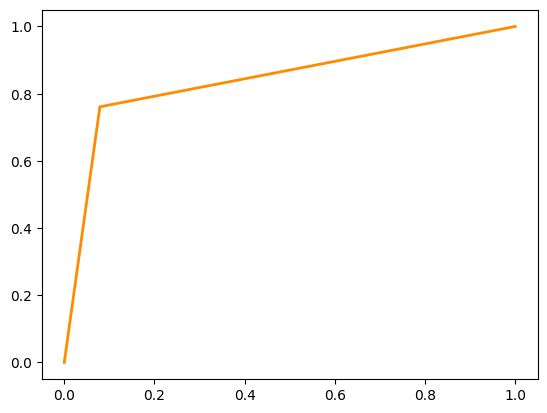

In [11]:
# Get the ROC curve

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_train_df, y_pred_train)

roc_auc = auc(fpr, tpr)

plt.figure()

plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)

In [17]:
# Plot the actual random forest
from sklearn import tree

plt.figure(figsize=(200, 200))
tree.plot_tree(clf.estimators_[0], filled=True)

plt.show()